# Implementing Machine Learning Systems from Scratch to Classify Songs by their Lyrics
## Team Members: Dylan Fox, Nicholas Francino, Tim Wang

# Part I: Introduction

Do you remember the song "Gangnam Style" that smashed the view record for YouTube, and the catchy dance that originated with it? Well, the artist who sang that song, Psy, has a quite profound quote: 

"The world's most famous and popular language is music". 

This quote does a great job of explaining why music is so important. Music is a powerful art form that sheds insight into a culture and a community's values. Since everyone in this project group is incredibly interested in music, and given music's importance, we wanted to use our data science project to explore music. We wanted to explicitly determine if given lyrics to a song, if we could predict that song's genre. 

We found this interesting because intuitively, it seems like songs from different genres do indeed have noticeable differences in their lyrics. For instance, rap songs probably have different tempos and different vocabularies than rock or country songs. One can imagine that if we sat a human in front of a computer and displayed to that human lyrics to many different songs, that human could probably classify the songs into their correct genres with pretty good accuracy. Our group wanted to see if we could do the same programatically using data science and machine learning techniques.

Besides this main goal of seeing how succesful we can be in classifying songs, we were also interested in organically creating a machine learning, text-classification pipeline and comparing it with some built in pipelines from well known libraries such as Sci-kit Learn. In this notebook, we will be implementing a Naive Bayes model from scratch. For a quick refresher on what a Naive Bayes model is, you can reference this: http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/, but later in this notebook we will introduce the model in more detail anyways.

Finally, this project has many real world, commercial impacts. There are many music streaming services such as Spotify or Pandora Radio, that put a lot of emphasis on processing songs and extracting patterns or meanings from songs in a programatic fashion. For instance, http://benanne.github.io/2014/08/05/spotify-cnns.html is a very interesting read on the combination of music and deep learning. This project attempts to do something similar, and perhaps some conclusions we draw can be applied in commercial settings. Most importantly, however, this is meant to be a tutorial and demonstration of how the entire data science pipeline should run and interact, and we hope you can take away a thing or two from some of the data integration or machine learning techniques we use. 

In [216]:
%%capture
# First thing's first! Install and import a lot of the necessary packages. 
!pip install unidecode
!pip install nltk
!pip install stop-words
!pip install wordcloud

import sqlite3
import pandas
import requests
import re
import unidecode
import nltk
import math
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from stop_words import get_stop_words 

from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')

# Part II: Data Collection and Cleaning

One of the most important parts to the data science pipeline is ingesting data. Since it is very difficult to find a dataset of raw song lyrics due to copyright issues, we instead have to create our own by scraping multiple websites.

We scraped the musicbrainz online music database, where they store song names, artists, albums, as well as a "tag" for genre (e.g.: https://musicbrainz.org/tag/rap/recording). Using information from this musicbrainz, we are then able to construct a Genius.com (https://genius.com/) url that we then scrape again to obtain the actual lyrics. To help with the scraping, we used the requests library to pull the HTML from the webpage, and then used the BeautifulSoup library to transform this HTML into something readable and useable. Furthermore, we define this function clean_string in order to take any string we are given and make it compatible with the Genius url.  This includes replacing "&" with "and", turning the unicode in the string to their respective ascii values, and removing all punctuation aside from dashes.  This allows us to easily construct the Genius url in order to scrape the lyrics from Genius.com.

We have set aside three static variables here: songList, which will keep hold of all of the song titles we see, genres, which represent the different classes of genres that we are interested in scraping, and then page_limit, which represents how many pages we want to scrape for each genre.  There are 200 songs on each page, which comes out to around 200 * pageLimit unique songs. To save computation time, we only scrape up to the 5th page of musicbrainz, but there are many more.

In [217]:
def clean_string(string):
    # Replace symbols with words
    cleaned_string = string.replace("&", "and")
    cleaned_string = unidecode.unidecode(cleaned_string)
    cleaned_string = re.sub(r'[^\w\s-]','',cleaned_string)

    return cleaned_string

# Static variables that will be used throughout this entire notebook 
songList = []
pageLimit = 5
genres = ['rap','christmas', 'country', 'rock']

# Loop through all of the genres and collect information about the song name, artist, and genre
for genre in genres:
    for num in range(1,pageLimit):
        # Target url from musicbrainz
        url = 'https://musicbrainz.org/tag/' + genre + '/recording?page=' + str(num) 
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        
        # Clean the results from the request
        list1 = soup.find_all("ul")[9]
        sublists = list1.find_all("li")
        
        # Extract song, artist, genre, etc from the request
        for elem in sublists:
            song_ref = elem.find_all("a")[0]
            song = song_ref.find_all("bdi")[0]
            artist_ref = elem.find_all("a")[1]
            artist = artist_ref.find_all("bdi")[0]

            cleaned_song = clean_string(song.get_text())
            cleaned_artist = clean_string(artist.get_text())

            songList.append([cleaned_song,cleaned_artist, genre])    

We add all of this data scraped from musicbrainz to a dataframe, storing the song name, artist, and genre of the respective song. We then drop all duplicate rows to reduce the number of repeating songs in our dataset. In the future, we will use this dataframe to scrape Genius.com.

In [304]:
df = pandas.DataFrame(songList, columns=['Song Name','Artist','Genre'])
df_nodup = df.drop_duplicates()

# Take 5 random rows from this dataframe to display
sample = df_nodup.sample(n = 5)
sample

,Song Name,Artist,Genre
1502,Oh Daddy,Fleetwood Mac,rock
1474,Kite,U2,rock
1039,Deeper Than Crying,Alison Krauss and Union Station,country
542,Away in a Manger,Vera Lynn,christmas
1451,Hey Joe,The Jimi Hendrix Experience,rock


From here we define a function that stems a document. This will be used later once we actually begin our scraping pipeline.

The process of stemming allows similar words to be grouped together in the bag-of-words model.  Words such as "cry", "cried", and "crying" will all be stemmed to base word "cri".  All of these words have the same base meaning and should be grouped together.  

Additionally, this function removes multiple stop_words from the document. This includes words that have little to no meaning, such as "i", "the", "a", and "and", which are so common they are useless and could potentially throw off our machine learning models in the future. You can find detailed documentation on the PorterStemmer here: http://www.nltk.org/_modules/nltk/stem/porter.html.

This effort is part of the process that we call data cleaning. While we have a lot of raw data, we still need to convert it into data that can be used effectively. 

In [219]:
stemmer = PorterStemmer()
stop_words = get_stop_words('english')
stop_words = set(map(lambda x: clean_string(x), stop_words))

# Method to stem words
def stem_document(document):
    newString = []
    
    # Split document into tokens
    tokens = word_tokenize(document)
    for token in tokens:
        # Stem each token
        stemmed = stemmer.stem(token)
        if(stemmed not in stop_words):
            newString.append(stemmed)
        
    return " ".join(newString)

Now, we iterate through the dataframe and scrape the lyrics of each song from the Genius.com webpage.  We do this by replacing all whitespace in a artist's song's name with a "-", concatenating them together, and adding the word "lyrics" to the end.  By sending an HTTP GET request to this URL, we can use BeautifulSoup to find the lyrics in the HTML that is returned.

If Genius.com has the song lyrics in it's database, then we find and clean the lyrics by removing all punctuation and any reference to the part of the song, which is always contained in braces. (Ex. [Chorus] or [Verse 1]).  We then stem the lyrics of the song and store them in a column of our dataframe.

If Genius.com cannot find the song, it always returns the string "sorry we didnt mean for that to happen".  In this case, we drop the song from our dataframe.

If the song is instrumental, Genius.com returns the string "instrumental".  In this case, we also drop the song from the dataframe, as songs without lyrics have no value to us.

In [220]:
%%capture
toDrop = []
df_nodup['Lyrics'] = ""

# Iterate through dataframe
for index,row in df_nodup.iterrows():
    # Build Genius URL
    artist = re.sub(r'\W+','-',row['Artist'].strip())
    song = re.sub(r'\W+','-',row['Song Name'].strip())
    genius_url = 'https://genius.com/' + artist + '-' + song + '-lyrics'
    
    # Send get request and use BeautifulSoup to parse the result
    r = requests.get(genius_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    lyrics = soup.find_all("p")[0]
    cleaned_lyrics = lyrics.get_text()
    
    # Deleting "Part of song" and all punctuation
    cleaned_lyrics = re.sub(r'\[.*\]','',cleaned_lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]','',cleaned_lyrics)
    cleaned_lyrics = cleaned_lyrics.lower()
    cleaned_lyrics = cleaned_lyrics.strip()
    
    # Check if invalid
    if(cleaned_lyrics.strip() == "sorry we didnt mean for that to happen" or cleaned_lyrics.strip() == "instrument"):
        toDrop.append(index)
    else:
        df_nodup.set_value(index,'Lyrics',stem_document(cleaned_lyrics))
           
df_cleaned = df_nodup.drop(df.index[toDrop])
df_cleaned.head(5)

# Part III: Exploratory Data Analysis

After we have completed gathering all of our data, it is often important to do a brief analysis of the data we collected to get a sense of what we are working with. This is called Exploratory Data Analysis, and usually consists of using graphs to gain some insight into the data we have to work with. 

For us, it is interesting to see exactly what words stand out the most in each genre. To visualize this, we created word_clouds using a WordCloud python library (you can view the source code here: https://github.com/amueller/word_cloud). In this visualization, words in a genre that occur larger have a higher frequency in that genre.

A little bit of ethics came into play here as well. One of the popular words in rap songs is the n-word. As data scientists, we have an obligation to make sure we produce results that are appropriate and consumable. This makes stradling the line between censoring particularly inappropriate content and being very open about one's data science process sometimes quite difficult. In this case, we did decide to censor the n-word because it is racially insensitive, but we decided to leave other curse words uncensored to maintain a certain level of transparency. 

In [305]:
def generate_wordcloud(genre):
    words = ""
    for index,row in df_cleaned.iterrows():
        if row['Genre'] == genre:
            words += " " + row['Lyrics']
    
    # Censor the n-word
    words = words.replace('nigga', 'n_gga')
            
    # Generate word clouds
    rap_wordcloud = WordCloud(background_color = None, mode = "RGBA").generate(words)
    plt.imshow(rap_wordcloud)
    plt.axis("off")
    plt.title("Word Cloud for: " + genre)
    plt.show()

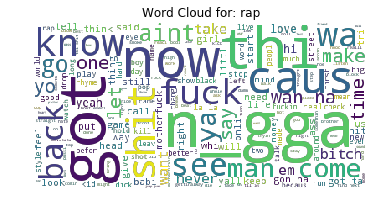

In [222]:
generate_wordcloud('rap')

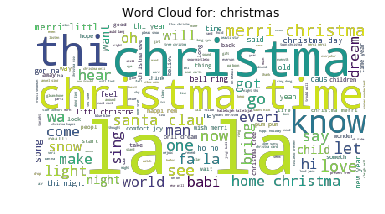

In [223]:
generate_wordcloud('christmas')

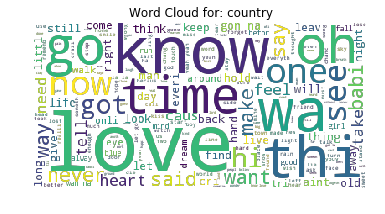

In [224]:
generate_wordcloud('country')

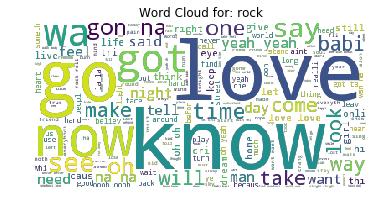

In [225]:
generate_wordcloud('rock')

Furthermore, we are also interested in the numbers regarding the songs and genres themselves. To visualize the amount of songs we have available for each genre, we construct a bar graph that tallies the amount of songs we have scraped for each genre. 

In [226]:
def count_num(genre):
    num = 0
    # Simply iterate through all of the rows and return the frequency of the genre that was passed in as a parameter
    for index,row in df_cleaned.iterrows():
        if row['Genre'] == genre:
            num = num + 1
    return num

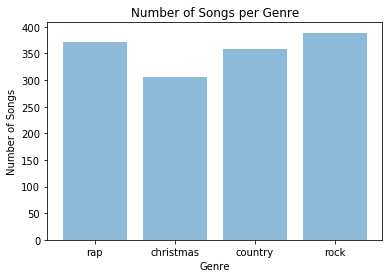

In [227]:
# Code to display a bar graph
y_pos = np.arange(len(genres))
performance = list(map(count_num, genres))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, genres)
plt.ylabel('Number of Songs')
plt.xlabel('Genre')
plt.title('Number of Songs per Genre')

plt.show()

As you can see, we have a pretty similar amount of songs for each genre. This makes us more confident that machine learning tehniques in the future won't overfit against genres that simply appear more frequently than others. 

## Part IV: Data Analysis - Machine Learning

In order to train and return a fair measure of how effective our model is, we split all of our data into training and testing sets. As typically done, we used a 70-30 split. Our test data is hereupon never touched upon again until we are ready to report the performance of our final models. This is the only way to report a fair measure of model performance. As you will see later, we use methods such as cross valdiation in order to create pseudo-test sets when we need them.  

In [228]:
train,test = train_test_split(df_cleaned, test_size = 0.3)

The model we want to build from scratch is a simple Naive Bayes model. The usage of this model will be as follows:

1. Take all of the song lyrics from our training set and split them into n-grams of a specified size. 
2. Aggregate all of the ngrams and combine counts of identical ngrams. This is the same as training our ngram model, and we need to maintain 1 model per genre. 
3. To predict on test data, simply take the test lyrics and split them into ngrams. Then, for each ngram, compute the Bayesian probability of that ngram belonging to each genre, and add it to that genre's running sum. 
4. Once we have finished computing the probabilities for each ngram, compare these running sums and simply pick the genre that has the max probability. 

We define the function combine_aggregates to take a list of dictionaries mapping n-grams to frequency, and returns a single dictionary that collapses all identical n-grams and maps to their total frequency.

In [229]:
from nltk import ngrams

### Given a list of dictionaries mapping ngrams -> counts, aggregate a master ngram->count dictionary computed from 
### these individual ones
def combine_aggregates(aggregate_dicts):
    to_return = aggregate_dicts[0]    
    
    # Empty dictionary
    if len(aggregate_dicts) == 0:
        return to_return
    
    # Aggregate counts
    for i in range(1, len(aggregate_dicts)):
        curr = aggregate_dicts[i]
        for k in curr:
            if k in to_return:
                to_return[k] += curr[k]
            else:
                to_return[k] = curr[k]

    return to_return            

### Given text and an ngram_size, creates an aggregate dict mapping ngrams to their frequency
def get_aggregate(text, ngram_size):
    aggregated = {}
    grams = ngrams(text.split(), ngram_size)
    for gram in grams:
        concatenated = ''
        for i in range(0, ngram_size):
            concatenated += gram[i] + ' '
        
        # Remove the last space at the end of the word
        concatenated = concatenated[:-1]
        
        if concatenated in aggregated:
            aggregated[concatenated] += 1
        else:
            aggregated[concatenated] = 1
            
    return aggregated

### Given text and an ngram_size, return a master aggregate dict containing ngram -> counts with ngrams ranging from size 
### 1 -> ngram_size
def get_ngrams(text, ngram_size = 2):
    all_aggregates = []
    for i in range(0, ngram_size):
         all_aggregates.append(get_aggregate(text, i + 1))
            
    return combine_aggregates(all_aggregates)

Crucial to our Naive Bayes model is this concept of a prior, which reflects our ratio of genres. This will become more clear in future once we show our prediction function.

In [230]:
# Given a genre and a dataframe, return how often songs from that genre appear in the dataframe
def get_prior(genre, df):
    return len(df.loc[df['Genre'] == genre]) / len(df.index)

# Store priors of each genre in this dict
genre_proportions = {}

for genre in genres:
    genre_proportions[genre] = get_prior(genre, train)

This is how we make a prediction for each song. Recall the Naive Bayes formula (http://www.saedsayad.com/images/Bayes_rule.png):

<img src="image.png">

We have calculated the priors in the cell above, and now we just need to model this formula. However, there is a slight twist. Somehow, we need to account for unseen words in the test set. Take for example the case where we are computing the probability for a certain ngram, but we have never encountered that ngram in our training data. Having a probability of 0 would be terrible for our model because since we actually have seen that ngram in the real world (through the test set), it just doesn't make sense to assign a frequency of 0. As a result, we must introduce smoothing. So, instead of assigning a frequency of 0, we shift all of the frequencies by a tiny amount. This leads to some changes and tinkering of the original Naive Bayes formula. 

Furthermore, it is obvious to see that simply taking the product of successive probabilities is problematic. The probabilities we assign each ngram are so small that, as the number of terms grow, these probabilities will approach ever closer to 0 since we are compounding tiny fractions. To alleviate this, we simply log transform every probability and instead of multiplying, we just add these log transformations together. 

To read even more about this technique, this resource will be very helpful: https://web.stanford.edu/class/cs124/lec/naivebayes.pdf

In [300]:
# Given lyrics, and the bag of words representation of a genre, and the prior of that genre, return 
# the log lilelihood of this song belonging to this genre
def make_prediction_for_genre(lyrics, bag_of_words, prior, smoothing_factor = 0.025):
    # Total size is the total number of words + the vocabulary * smoothing_factor
    total_size = sum(bag_of_words.values()) + smoothing_factor * len(bag_of_words)
    total_probability = 0
    
    # Loop through all of the terms
    for term in lyrics:
        # Grab frequency of how many times this ngram appeared in the song
        cardinality = lyrics[term]
        for i in range(0, cardinality):
            freq = 0
            if term in bag_of_words:
                freq = bag_of_words[term]
            
            # Compute our modified version of the Naive Bayes formula
            total_probability += math.log((prior * freq + smoothing_factor)/ total_size)
    
    return total_probability
    
# Given the song lyrics and an ngram_model, and the dataframe of songs and genres, return what Genre maximizes the log likelihood of 
def predict(song_lyrics, ngram_model,ngram_size):
    max_score = float('-inf')
    max_genre = ''
    ngrams = get_ngrams(song_lyrics, ngram_size)
    
    # Loop through each genre and make a prediction for that genre. Keep track of the max score and max genre as we go
    for genre in genres:
        score = make_prediction_for_genre(ngrams, ngram_model[genre],genre_proportions[genre])

        if(score > max_score):
            max_genre = genre
            max_score = score
            
    return max_genre

This is where we train our model. We have a method called create_genre_bag_of_words that will construct an ngram model for a specific genre. We store all of the models we train in a dictionary called genre_bags that maps a genre name to the ngram model associated with this. Note that we use bag of words and ngram model interchangably because in this notebook, we only train ngram models where ngram size = 1.

In [247]:
# Creates a frequency mapping for each genre 
def create_genre_bag_of_words(df,genre, ngram_size):
    genre_df = df.loc[df['Genre'] == genre]
    
    # List of all ngrams
    terms = []
    for index,row in genre_df.iterrows():
        terms.append(get_ngrams(row['Lyrics'],ngram_size))
    
    # Aggregate all of the ngrams
    aggregate = combine_aggregates(terms)
    return aggregate
    
    
# Train an ngram model for each 
genre_bags = {}
for genre in genres:
    genre_bags[genre] = create_genre_bag_of_words(train,genre,1)

Here, we train and test our Naive Bayes model and report its accuracy. 

In [248]:
num_correct = 0
raw_predictions = []

# Iterate through the test dataframe
for index,row in test.iterrows():   
    # Make a prediction and store it
    prediction = predict(row['Lyrics'],genre_bags,1)
    raw_predictions.append(prediction)
    
    if(prediction == row['Genre']):
        num_correct += 1

# Report our accuracy
print('Accuracy for our custom Naive Bayes model: ' + str(num_correct / len(test)))

Accuracy for our custom Naive Bayes model: 0.7406542056074766


After creating and training our Bayesian model from scratch, we found it may be interesting to see how our model compares to the built in models from Scikit-Learn.  Here, we build a pipeline that trains a Multinomial Bayesian classifier using the Scikit-Learn library. This pipeline automatically abstracts the data processing, training, and testing steps for us. You can read its documentation here: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html.

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Build the training-testing pipeline
bayes_clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])

bayes_clf.fit(train['Lyrics'],train['Genre'])
print('Accuracy for Scikit-Learn\'s Naive Bayes model: ' + str(np.mean(bayes_clf.predict(test['Lyrics']) == test['Genre'])))

Accuracy for Scikit-Learn's Naive Bayes model: 0.754672897196


While Scikit-Learn's Multinomial Naive Bayes model does not have a huge variety of parameters, most of their other models do. Understanding that a change in parameters can lead to huge swings in prediction ability, we decided to implement many different versions of each model with slightly different parameters and use 10-fold Cross Validation to choose the one that performed the best. This is very similar to a process known as hyperparameter searching, although in this notebook we settle for a simpler version as we do not have the computing power to process all possible model variants.

Diving deeper into cross-validation, cross-validation is a way to make pseudo-test sets as mentioned earlier in this notebook. 10-fold cross validation essentially splits the data set into 90 - 10 partitions. It trains a model on the 90% partition and tests it on the 10% partition, and repeats this process 10 times. Thus, each data point has a good chance of being both trained with and tested upon. It is important to notice that without this procedure, or something similar, there is no way we can choose between different model parameters. Using the actual test set to pick the best performing model is unfair because it overfits to the test set. Thus, cross validation is an extremely important and useful process. Below, we define a method that can help with cross validation. A great summary of cross validation can be found here: https://www.openml.org/a/estimation-procedures/1.

In [263]:
from sklearn.model_selection import KFold

# Cross validation method that takes in a dictionary of classifiers.
# This dictionary is expected to map from a classifier to a list. This list will be populated with error on the test set
# for each of the folds
def run_cross_validation(classifiers, folds = 10):
    # Create 10-fold cross validation partitioner
    kf = KFold(n_splits=10)
    
    # 10 Fold Cross Validation
    for train_, test_ in kf.split(X_train):
        # Split into train/test input and output
        input_train = []
        input_test = []
        output_train = []
        output_test = []
    
    # Create training set
    for i in train_:
        input_train.append(X_train[i][0])
        output_train.append(X_train[i][1])
    
    # Create test set
    for i in test_:
        input_test.append(X_train[i][0])
        output_test.append(X_train[i][1])
        
    # Loop over classifiers and train and test them each
    for clf in classifiers:
        scores = classifiers[clf]
        clf.fit(input_train, output_train)
        scores.append(np.mean(clf.predict(input_test) == output_test))
    
    # Compute mean test error for each classifier
    for clf in classifiers:
        scores = classifiers[clf]
        classifiers[clf] = np.mean(scores)
    
    # Return the model that maps to the best score
    return max(classifiers.keys(), key=lambda k: classifiers[k])
    

Here, we run cross validation on our support vector machines. We varied parameters primarily by the kernel of the SVM, which sometimes gives the SVM more power to fit more descriptive curves. Read documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.

In [267]:
from sklearn.svm import SVC
from random import *

# First, reformat the training data so that it can be used in our cross validation
X_train = []
for i,r in train.iterrows():
    data_point = []
    data_point.append(r['Lyrics'])
    data_point.append(r['Genre'])
    X_train.append(data_point)

    
# Define dictionary of possible models to consider
svm_models = {}

svm_models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SVC(kernel = 'sigmoid'))])] = []

svm_models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SVC(kernel = 'linear'))])] = []

# Get the SVM that performed the best during cross validation
best_svm = run_cross_validation(svm_models)

# Now, actually train and test it
best_svm.fit(train['Lyrics'],train['Genre'])
print('Accuracy for Scikit-Learn\'s SVM: ' + str(np.mean(best_svm.predict(test['Lyrics']) == test['Genre'])))

Accuracy for Scikit-Learn's SVM: 0.773364485981


We can do the same for other different types of classifiers that Scikit-Learn offers. Here, we do so with a SGDClassifier, a linear classifier that is specifically trained with stochastic gradient descent, a type of optimization algorithm that is extremely efficient for large datasets. We mostly varied our parameters by loss function and regularization type. Read documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.

In [271]:
# Define a handful of different SGD Models
SGD_Models = {}
SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='log', penalty='l2',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='perceptron', penalty='elasticnet',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='hinge', penalty='elasticnet',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='log', penalty='elasticnet',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='perceptron', penalty='elasticnet',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='hinge', penalty='l1',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

SGD_Models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='log', penalty='elasticnet',
                    alpha=1e-3, random_state=randint(1,100)))])] = []

# Get the SGD MOdel that performed the best during the cross validation
best_sgd = run_cross_validation(SGD_Models)

# Now, actually train and test it
best_sgd.fit(train['Lyrics'],train['Genre'])
print('Accuracy for Scikit-Learn\'s SGD Model: ' + str(np.mean(best_sgd.predict(test['Lyrics']) == test['Genre'])))

Accuracy for Scikit-Learn's SGD Model: 0.754672897196


The last model we will test is a tree-like model, namely a Random Forest. We mostly varied parameters by the number of estimators. Read documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

In [291]:
from sklearn.ensemble import RandomForestClassifier
rf_models = {}
rf_models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(n_estimators = 500))])] = []

rf_models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(n_estimators = 10))])] = []

rf_models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(n_estimators = 25))])] = []

rf_models[Pipeline([('vect', CountVectorizer(stop_words = stop_words,ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(n_estimators = 50, oob_score = True))])] = []

best_rf = run_cross_validation(rf_models)
best_rf.fit(train['Lyrics'],train['Genre'])
print('Accuracy for Scikit-Learn\'s Random Forest Model: ' + str(np.mean(best_rf.predict(test['Lyrics']) == test['Genre'])))

Accuracy for Scikit-Learn's Random Forest Model: 0.717289719626


Although we have now trained many models and have a general overview of their predictive power, we can get an even more detailed view using ROC curves. A ROC curve plots a model's true positive rate along its false positive rate. This gives us insight into the true performance of a model. Imagine a scenario where we are trying to predict a very rare event. If we have a classifier that simply never predicts that event, that classifier will have a very high prediction accuracy score, but its true positive, false positive relationship will definitely deteriorate and are a better reflection of how poor a model it is. As a result, the area under the curve of a ROC curve is generally perceived as the best estimator of how well a model performs. 

Finally since we are performing multi-class predictions, we have to transform our ROC curve into a 1 vs. all setting. Meaning, we will have one ROC curve for each genre, where for that ROC curve, we treat any prediction that is not the true genre as a false prediction. 

In [306]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def print_roc(predictions, test, genres, plot_title):
    # Create one plot for each genre
    for genre in genres:
        truth = []
        
        # Convert string predictions into a binary setting
        for i,r in test.iterrows():
            if r['Genre'] == genre:
                truth.append(1.0)
            else:
                truth.append(0.0)
        
        # Making it 1 vs. all
        pred = []
        for p in predictions:
            if p == genre:
                pred.append(1.0)
            else:
                pred.append(0.0)
        
        # Display the graphs
        false_positive_rate, true_positive_rate, thresholds = roc_curve(truth, pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.title(plot_title + ' Genre: ' + genre)
        plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([0,1.0])
        plt.ylim([0,1.0])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    

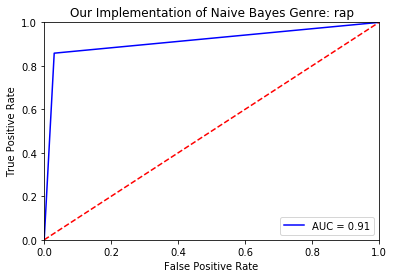

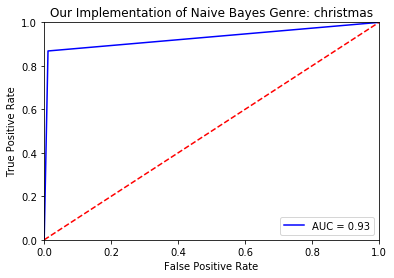

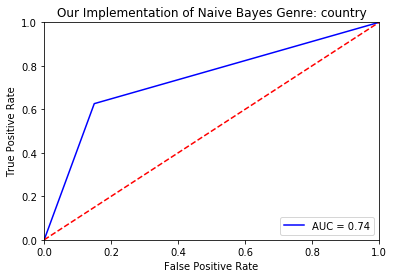

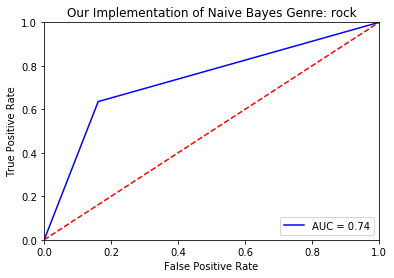

In [293]:
print_roc(raw_predictions, test, genres, 'Our Implementation of Naive Bayes')

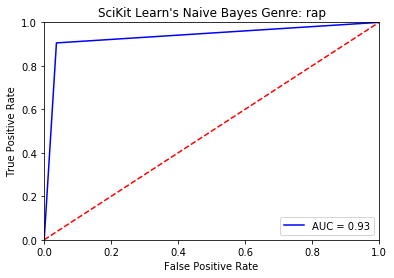

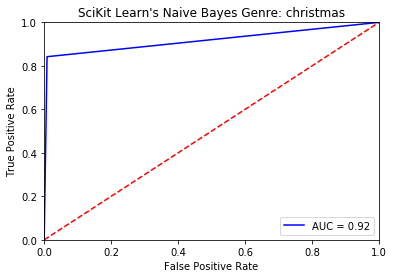

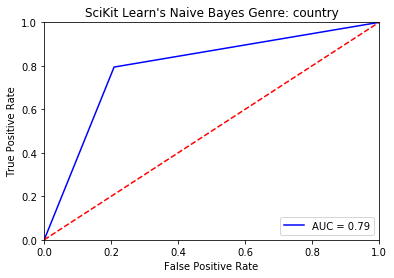

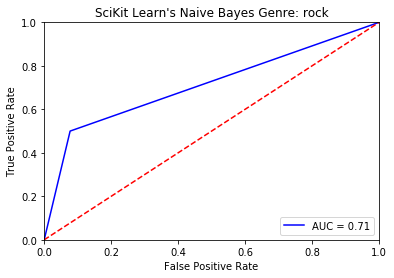

In [294]:
print_roc(bayes_clf.predict(test['Lyrics']), test, genres, 'SciKit Learn\'s Naive Bayes')

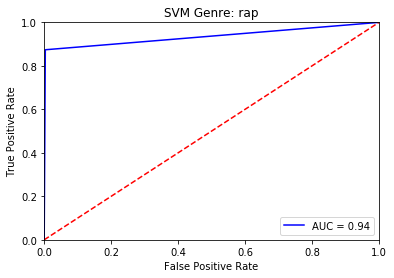

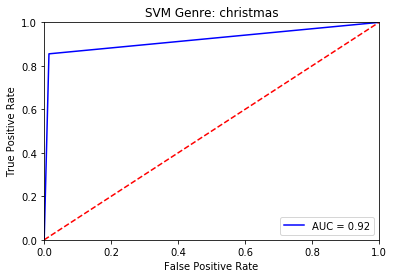

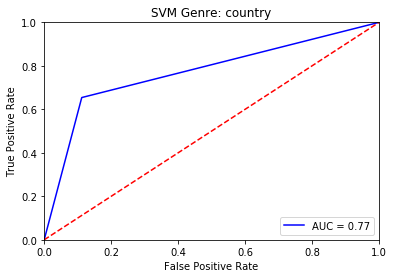

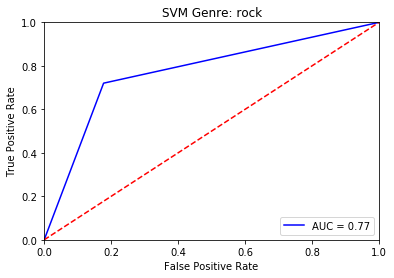

In [295]:
print_roc(best_svm.predict(test['Lyrics']), test, genres, 'SVM')

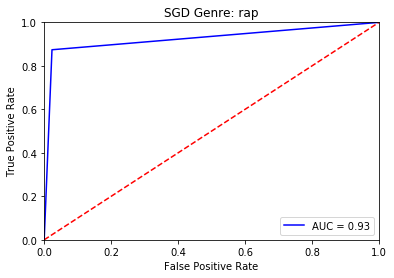

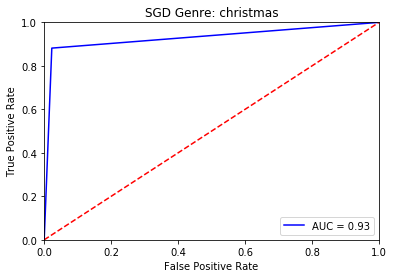

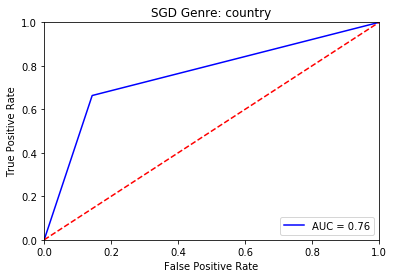

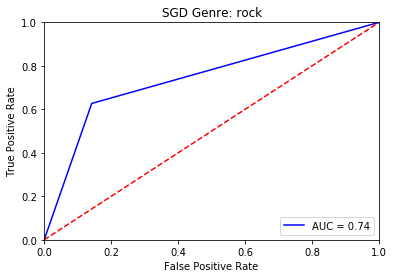

In [296]:
print_roc(best_sgd.predict(test['Lyrics']), test, genres, 'SGD')

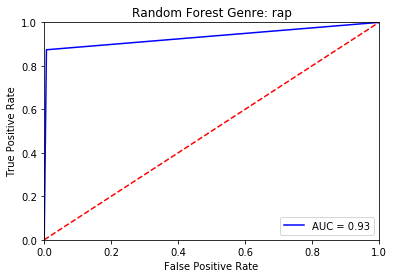

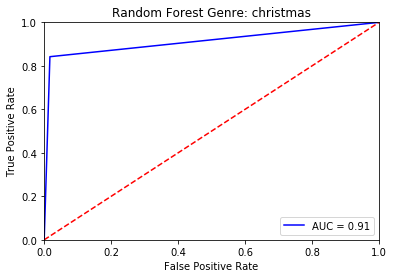

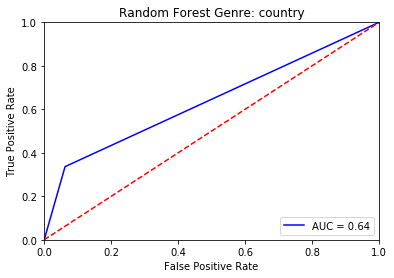

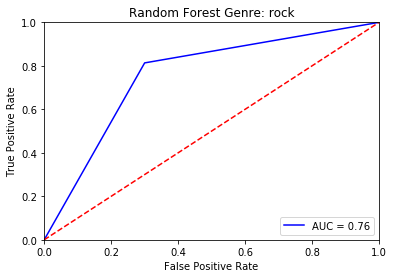

In [297]:
print_roc(best_rf.predict(test['Lyrics']), test, genres, 'Random Forest')

Interestingly enough, there seems to be a general pattern that models have very high ROC areas when predicting against rap and christmas, but much lower when trying to predict country and rock songs. This can be attributed to the fact that rock and country songs are just so similar that it can be difficult to tell them apart while rap and christmas songs are more different. This can be seen via a closer look at the word clouds we generated earlier. 

# Part V: Analysis of Results

As mentioned in our introduction, one goal was to compare our implementation to built-in models provided by Scikit-Learn. Now that we have the code to test these models, we can perform a hypothesis test to determine whether or not we statistically outperform or are outperformed by Scikit-Learn's models. To accomplish this, we can perform a 1-tailed t-test. 

What is a t-test? Firstly, we need to explain what a hypothesis test is- it is when we want to make a conjecture about the statistical relationship between two variables and perform a statistical test to determine whether or not that relationship is explained by random chance or actual statistical difference. A t-test is a specific type of hypothesis test, and is a way to test differences between samples when we aren't given information about any truths about the actual population such as the true population mean or variance. 

In our case, we want to test the differences in the predictions made by our model and Scikit-Learn's models on our sample test set and see if the predictions vary significantly, namely if Scikit-Learn's models outperforms ours. Our null hypothesis, or claim we attempt to refute with this test, is that the Scikit-Learn models do not outperform ours.


In [298]:
from scipy import stats

# Now, we need to generate the sample predictions for our model and Scikit-Learn's models
our_predictions = []
nb_predictions = []
svm_predictions = []
sgd_predictions = []
rf_predictions = []

# Truth values
truth = []

# Make predictions on test and store them
for i,r in test.iterrows():
    our_predictions.append(predict(r['Lyrics'],genre_bags,1))
    nb_predictions.append(bayes_clf.predict([r['Lyrics']])[0])
    svm_predictions.append(best_svm.predict([r['Lyrics']])[0])
    sgd_predictions.append(best_sgd.predict([r['Lyrics']])[0])
    rf_predictions.append(best_rf.predict([r['Lyrics']])[0])

    truth.append(r['Genre'])

# Now, we need to transform our predictions into numerical values: 1 if we predicted correctly, else 0
for i in range(0, len(truth)):
    if our_predictions[i] == truth[i]:
        our_predictions[i] = 1
    else:
        our_predictions[i] = 0
        
    if nb_predictions[i] == truth[i]:
        nb_predictions[i] = 1
    else:
        nb_predictions[i] = 0
        
    if svm_predictions[i] == truth[i]:
        svm_predictions[i] = 1
    else:
        svm_predictions[i] = 0
        
    if sgd_predictions[i] == truth[i]:
        sgd_predictions[i] = 1
    else:
        sgd_predictions[i] = 0
        
    if rf_predictions[i] == truth[i]:
        rf_predictions[i] = 1
    else:
        rf_predictions[i] = 0

# Now, we can perform the actual t-test using built-in helper functions from Scipy. Note that this built in function
# by default performs a 2-tailed t-test. Since we are only interested in one direction (whether we are outperformed), 
# we can just divide this p-value by 2.

nb_vs_us = stats.ttest_ind(nb_predictions, our_predictions, axis=0, equal_var=False)[1] / 2
svm_vs_us = stats.ttest_ind(svm_predictions, our_predictions, axis=0, equal_var=False)[1] / 2
sgd_vs_us = stats.ttest_ind(sgd_predictions, our_predictions, axis=0, equal_var=False)[1] / 2
rf_vs_us = stats.ttest_ind(rf_predictions, our_predictions, axis=0, equal_var=False)[1] / 2


In [302]:
print('P-Value- (Scikit-Learn\'s Naive Bayes vs. Us): ' + str(us_vs_nb))
print('P-Value- (Scikit-Learn\'s SVM vs. Us): ' + str(svm_vs_us))
print('P-Value- (Scikit-Learn\'s SGD vs. Us): ' + str(sgd_vs_us))
print('P-Value- (Scikit-Learn\'s RF vs. Us): ' + str(rf_vs_us))

P-Value- (Scikit-Learn's Naive Bayes vs. Us): 0.318648557341
P-Value- (Scikit-Learn's SVM vs. Us): 0.132538978539
P-Value- (Scikit-Learn's SGD vs. Us): 0.318648557341
P-Value- (Scikit-Learn's RF vs. Us): 0.221254533554


To determine whether or not our we can reject our hypothesis, we need to compare our p-value to some confidence level. If we select a confidence level of .05, then we realize that we cannot reject any of the null hypotheses we put forward. As a result, we cannot say that we were statistically significantly outperformed by any of Scikit-Learn's built in models. 

# Part VI: Conclusion and General Remarks

As all of the models hovered around the mid 70% mark for accuracy, we can conclude that there are pretty significant differences in song lyrics across genres that machine learning algorithms can pick up on. You can imagine a very naive classifier that just randomly guesses a genre. We have 4 different genres, so this classifier would have about 25% accuracy. Our custom Naive Bayes implementation as well as all of Scikit-Learn's models vastly outperform this. This suggests that, using just the words in songs, we can gauge pretty well what genre that song is from, which confirms our initial heuristic that there is inherent structure present in song lyrics themselves, and that there are definitely keywords within songs that indicate what genre that song belongs to. An interesting investigation would be an unsupervised foray into song lyrics and see if there is a more latent structure to these lyrics. 

Furthermore, it is important to understand the limitations of our approach. Since we used ngrams of size 1, our machine learning algorithms were simply trying to find patterns in song vocabulary. As one can imagine, predictive power would surely increase if we decided to increase our features and instead of just looking at vocabulary, looked at things such as tempo, or verse length. An easy way to make this change would just be to add special tokens to signify the start and end of each verse line. Then, if we increased our ngram size from 1 to 2, we could maybe capture some context about when lines end and what types of words start and end verses. This might increase predictive power and it is a well documented fact that ngrams of size 2 (called bigrams) generate pretty good models given their simplicity (see: http://www.aclweb.org/anthology/P/P12/P12-2.pdf#page=118). We have code in this notebook that can generate ngrams up to any size, and we'll leave it to the reader to pursue this option if they wish.

Another way we can improve results is to implement a more advanced smoothing technique. Currently, in the method make_prediction_for_genre, we only utilize simple Laplacian Smoothing. This means we set aside a constant amount of probability density for each unseen word. This technique grows the amount of probability density allocated for unseen words directly proportional to how often we see terms in the test data that are not present in our training set. It is now obvious to realize that this method performs very poorly whenever we see a lot of unfamiliar terms in our test data, because an inappropriate amount of probability density gets allocated to these "rare" events. As a result, many Laplacian smoothing techniques fail in this scenario because setting aside constant space is no longer a good estimator for rare events. 

A much better approach uses observed data to estimate unobserved data. One famous example of this type of smoothing is called Simple Good-Turing or (SGT). Here is a link to a paper that does a great job explaining this technique: https://pdfs.semanticscholar.org/3c0f/046634f8102c2acb495aaf7f14924c2d4ee7.pdf. This Quora blog post is also extremely helpful: https://beyondexpectations.quora.com/An-Intuitive-Explanation-of-Good-Turing-Smoothing.  